## Language Modelling with tensorflow and RNN
![RNN LSTM](https://farm1.staticflickr.com/823/28194204998_ccbd89bee6.jpg)


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import sys
import re
from datetime import datetime
from collections import Counter
import nltk
import nltk.corpus

print(sys.version)
print(tf.__version__)
hello = tf.constant('Hello, TensorFlow!')
sess = tf.Session()
print(sess.run(hello))

device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
    device = device_name
else:
    device = '/cpu:0'
    print('GPU device not found, use CPU instead')
# print('Found GPU at: {}'.format(device_name))


3.6.3 (default, Oct  3 2017, 21:45:48) 
[GCC 7.2.0]
1.8.0
b'Hello, TensorFlow!'
Found GPU at: /device:GPU:0


##download NLTK text corpus

In [0]:
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> punkt
      Package punkt is already up-to-date!

---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> webtext
      Package webtext is already up-to-date!

---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identif

True

## Build vocab object
A vocab object holds each word and its ID, used to convert to and from each other

In [0]:
class Vocab:
    
    def __init__(self, words=[], bos='<bos>', eos='<eos>', unknown_word='<unk>', 
                 to_lower_case=True,
                 grow_missing_id=True):
        self.append_id = grow_missing_id
        self.word_id = 0
        self.to_lowercase = to_lower_case
        self.id_words = ['<PAD>', unknown_word]
        self.word_id_map = {}
        
        for w in self.id_words:
            self.word_id_map[w] = self.word_id
            self.word_id += 1
        
        
        if bos:
            self.id_words.append(bos)
            self.word_id_map[bos] = self.word_id
            self.word_id += 1
            
        if eos:
            self.id_words.append(eos)
            self.word_id_map[eos] = self.word_id
            self.word_id += 1

        for w in words:
            if self.to_lowercase:
                w = w.lower()
                
            # add new words    
            if w not in self.word_id_map:
                self.word_id_map[w] = self.word_id
                self.id_words.append(w)
                self.word_id += 1
                
                
    def __len__(self):
        return len(self.id_words)
      
    def size(self):
      return __len__(self)
    
    # return unknown word id for words that are never seen
    def get_id(self, word):
        return self.word_id_map[word] if word in self.word_id_map else 1
                
    def get_word(self, id):
        return self.id_words[id]
    
    def get_all_words(self):
        return self.id_words[1:]
    
    def add(self, word):
        if self.to_lowercase:
            word = word.lower()
            
        # new word, only add when grow/append flag is true
        if word not in self.word_id_map and self.append_id:
            self.word_id_map[word] = self.word_id
            self.id_words.append(word)
            self.word_id += 1

    def add_from_list(self, word_list):
        for w in word_list:
            self.add(w)


##Test Vocab class

In [0]:
words = ['<bos>','I','am','to','dream','bigger','dreams','<eos>']
vocab = Vocab(words, to_lower_case=True,grow_missing_id=False )
ids = [vocab.get_id(x.lower()) for x in words]
print ('ids =', ids)
print ('words=', [vocab.get_word(id) for id in ids])

unknown_word = 'blaienlkein'
print (vocab.get_word(5))
print (unknown_word, ' id=', vocab.get_id(unknown_word))

# grow_missing is False, so the following won't be added
vocab.add('banana')
print (vocab.get_id('banana'))
print ('vocab size=', len(vocab))
assert len(vocab) == len(words) + 2  # PAD, UNK

ids = [2, 4, 5, 6, 7, 8, 9, 3]
words= ['<bos>', 'i', 'am', 'to', 'dream', 'bigger', 'dreams', '<eos>']
am
blaienlkein  id= 1
1
vocab size= 10


In [0]:
# !pip install -U -q PyDrive

# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# # 1. Authenticate and create the PyDrive client.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

# # # PyDrive reference:
# # # https://googledrive.github.io/PyDrive/docs/build/html/index.html

# # # # 2. Create & upload a text file.
# # uploaded = files.upload()
# # print('Uploaded file with ID {}'.format(uploaded.get('id')))

# # # 3. Load a file by ID and print its contents.
# # downloaded = drive.CreateFile({'id': uploaded.get('id')})
# # print('Downloaded content "{}"'.format(len(downloaded)))

# file = drive.CreateFile({'id':'19hWE6u5RBx5tlf_ArwYukSRFAViZO-zu'})
# file.GetContentFile('google-10000-english-no-swears.txt')



## A Config object to hold the Networks configurations, such as unroll length, hidden units etc.

In [0]:
class Config(object):
  """parameters config."""
  init_scale = 0.1
  learning_rate = 0.001
  num_steps = 5
  hidden_size = 200
  embedding_size = 120
  max_epoch = 5
  keep_prob = 0.6
  lr_decay = 0.5
  batch_size = 128
  
config = Config()

#use the most frequent 10k words from the corpus as vocab, all other words will be mapped to a special token: ``<unk>``

In [0]:
from nltk.corpus import webtext
from nltk.corpus import gutenberg
from collections import Counter

max_words = 10000
vocab = Vocab()
sents = webtext.sents() + gutenberg.sents()
cnt = Counter()

for sent in sents:
#     print(sent)
    for w in sent:
        if re.match('\w+',w):
            w = w.lower()
            cnt[w] += 1
        
for w,v in cnt.most_common(max_words):
#     print('top words:', w, v)
    vocab.add(w)
    
    
print('vocab =', len(vocab))
    
    

vocab = 10004


## A mthod to transform list of words to fix-length word IDs

Tensorflow static_rnn requires the input is of the shape [batch_size, sequence_length]
short sentence will be padded with id 0 to make it to the fix-length
long setnence will be splitted into multiple chunks, each with length 'sequence_length' 
Also, beginning of sentence (**bos**) and end of sentence (**eos**) tokens will be added to each sentence.



In [0]:
def transform_corpus(sents, vocab, length, max_lines=2**63, pad_id=0):
    '''
    pad nltk corpus and turn it into ids
    '''
    data = np.zeros((0,length), dtype=np.int16)
    cnt = 0
    for sent in sents:
        if cnt >= max_lines:
            break
            
        sent = ['<bos>'] + sent + ['<eos>']    
        start_idx = 0
        while(start_idx + length < len(sent)):
            
            ids = list(map(lambda w: vocab.get_id(w.lower()), sent[start_idx:start_idx+length]))
            data = np.vstack((data, ids))
            start_idx += length
            
        #left over
        ids = list(map(lambda w: vocab.get_id(w.lower()), sent[start_idx:]))
        # padding
        ids += [pad_id] * (length - len(sent[start_idx:]))
        data = np.vstack((data, ids))
        
        cnt += 1
        if cnt % 10000 == 0:
            print('[%s] %d sentences read'%(datetime.now().strftime('%H:%M:%S'),cnt))
    return data

In [0]:
'''
test transform_corpus()
'''
test_sent = ['After some discussion with my colleagues and some investigation of the framework I am using'.split()]
test = transform_corpus(test_sent, vocab, 5)
print(test)


[[   2   94   95 6707   19]
 [  29    1    5   95    1]
 [   6    4    1    9   99]
 [ 843    3    0    0    0]]


## Split data into feature set and label set, because the task is to predict the next word, the labels are just the feature set shifted by 1

In [0]:
data_np = transform_corpus(sents, vocab, length=config.num_steps+1, max_lines=500000)
n_training = int(data_np.shape[0] * 0.9)
print(data_np.shape)

training_data = data_np[:n_training, :-1]
training_labels = data_np[:n_training, 1:]

validating_data = data_np[n_training:, :-1]
validating_labels = data_np[n_training:, 1:]


[18:10:51] 10000 sentences read
[18:10:58] 20000 sentences read
[18:11:12] 30000 sentences read
[18:11:39] 40000 sentences read
[18:12:32] 50000 sentences read
[18:13:30] 60000 sentences read
[18:14:53] 70000 sentences read
[18:16:12] 80000 sentences read
[18:17:54] 90000 sentences read
[18:20:06] 100000 sentences read
[18:23:28] 110000 sentences read


In [0]:
print('training set shape:', training_data.shape)
print('last word=', vocab.get_word(9900))
rand = random.randint(0,len(training_data))
n = 5
print('%d random snapshot of training: %s'%(n,[vocab.get_word(x) for x in training_data[rand]]))
print('%d random snapshot of training: %s'%(n,training_data[rand]))

print('%d random snapshot of training: %s'%(n,[vocab.get_word(x) for x in training_labels[rand]]))
print('%d random snapshot of the labels: %s'%(n,training_labels[rand]))

training set shape: (535988, 5)
last word= hag
5 random snapshot of training: ['<unk>', '<unk>', '<unk>', '<eos>', '<PAD>']
5 random snapshot of training: [1 1 1 3 0]
5 random snapshot of training: ['<unk>', '<unk>', '<eos>', '<PAD>', '<PAD>']
5 random snapshot of the labels: [1 1 3 0 0]


In [0]:
class Trainer:
  
    def __init__(self, vocab_size, config):
        tf.reset_default_graph()
        # [batch_size, time_steps]
        self.config = config
        self.vocab_size = vocab_size
        self.optimizer = tf.train.AdamOptimizer(learning_rate=config.learning_rate)
        
    
    def _create_model(self, config, is_training=True):                
        # Embedding layer
        with tf.device(device):

            self.embedding_table = tf.get_variable("word_embeddings",
                                                   None,
                                                   initializer=
                                                   tf.random_normal((self.vocab_size, config.embedding_size), 
                                                   seed=42
                ))
            
            self.embeddings = tf.nn.embedding_lookup(self.embedding_table, self.x)
            # embedding table shape:[batch, num_steps, embedding_size]
            print('embedding shape=', self.embeddings.get_shape())
#             if is_training and config.keep_prob < 1: 
#                 self.x = tf.nn.dropout(self.x, config.keep_prob) 

        with tf.device(device):
            #LSTM layer
            output, self.next_state = self._build_rnn_graph(self.embeddings, 
                                                                 config,
                                                                 is_training)
             
            #  how is this different from : 
            #  output = tf.concat(output, 0)
          
            # output is [[batch, hidden_size],[batch, hidden_size],...,], size = seq_len
            output = tf.reshape(tf.concat(output, 1), [-1, config.hidden_size])
            print('lstm output =', tf.shape(output))
        
            softmax_w = tf.get_variable("W", 
                                        [config.hidden_size, self.vocab_size], 
                                        dtype=tf.float32, 
                                        initializer=tf.contrib.layers.xavier_initializer()) 
            softmax_b = tf.get_variable("bias", [self.vocab_size], dtype=tf.float32) 

            print('softmax_w shape=', softmax_w.shape)
            print('softmax_w shape=', tf.shape(softmax_w))
            print('softmax_b shape=', softmax_b.shape)  
            logits = tf.nn.xw_plus_b(output, softmax_w, softmax_b)

            
            # Reshape logits to be a 3-D tensor for sequence loss
            logits = tf.reshape(logits, [tf.shape(self.x)[0], config.num_steps, self.vocab_size])
            print ('logits shape=', tf.shape(logits))

            self._prediction = tf.nn.softmax(logits)
            
#             # Use the contrib sequence loss and average over the batches
            loss = tf.contrib.seq2seq.sequence_loss(
                logits,
                self.y,
                tf.ones([tf.shape(self.x)[0], config.num_steps]),
                average_across_timesteps=True, # False
                average_across_batch=False)
            
            # no need to use one-hot encoding as output when use sparse_softmax 
#             loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
#                 logits=logits, labels=self.y)

        # for some reason mean won't run on GPU
        with tf.device('/cpu:0'):
            self.loss = tf.reduce_mean(loss)
            loss_scalar = tf.summary.scalar("mean_loss", self.loss)
#             loss = tf.reduce_mean(loss)
            # Update the cost
#             self.loss = loss
            self.train_op = self.optimizer.minimize(loss)
        
    
    def _build_rnn_graph(self, inputs, config, is_training):
        cell = tf.nn.rnn_cell.LSTMCell(config.hidden_size, 
                                       forget_bias=0.0, 
                                       state_is_tuple=True, 
                                       reuse=not is_training)
        self.initial_state = cell.zero_state(tf.shape(self.x)[0], tf.float32)

        #Dropout
        if is_training and config.keep_prob < 1:
          cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=config.keep_prob)
        
        # turn inputs [batch_size, num_steps, embedding_size] into a list of [batch_size, embedding_size], of length num_steps
        inputs = tf.unstack(inputs, num=config.num_steps, axis=1)
        print('unstack inputs[0].shape = ', inputs[0].shape)
        output, next_state = tf.nn.static_rnn(cell=cell, 
                                              inputs=inputs, 
                                              dtype=tf.float32, 
                                              initial_state=self.initial_state)
        return output, next_state
      
    
    def save_model(self, session, path='model.pickle'):
        saver = tf.train.Saver()
        saver.save(session, path)
        return path
        
    def load_model(self, saver, session, path):
        saver.restore(session, path)
#         print("Model restored.")
      
      
    def train(self, features, labels):
        dataset = tf.data.Dataset.from_tensor_slices((features, labels))\
                                 .shuffle(config.batch_size*1000)\
                                 .batch(config.batch_size)
#         dataset = tf.data.Dataset.from_tensor_slices((features, labels))#.repeat(3)
# .apply(tf.contrib.data.batch_and_drop_remainder(config.batch_size))
        iter = dataset.make_initializable_iterator()
        self.x, self.y = iter.get_next()
        self._create_model(config=self.config, is_training=True)
        
        counter = 1
        saver = tf.train.Saver()
        with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
            sess.run(tf.global_variables_initializer())
            cost = []
            
            for e in range(self.config.max_epoch):
                sess.run(iter.initializer) 
                
                try:
                    while(True):
#                         state = sess.run(self.initial_state)
                        _, x_entropy, cur_input = sess.run(
                            [self.train_op, self.loss, self.x])
#                         print("first example in batch:", cur_input[0])
                        cost.append(x_entropy)
                        if counter % 10 == 0:
                            print('%s, epoch:%d, batch:%d, batch_shape=%s, entropy/pp=%f/%f, '
                                  %(datetime.now().strftime('%H:%M:%S'), 
                                    e+1, 
                                    counter, 
                                    cur_input.shape, 
                                    x_entropy, np.exp(x_entropy))) 
                        counter += 1
                        
                except tf.errors.OutOfRangeError:
                    counter = 1
                    #save model after each epoch 
                    save_to = '/tmp/model.pickle'
                    print("saving model to: %s" % save_to)
                    saver.save(sess, save_to)
                
        return cost           

    def test(self, session, x):
#         with tf.Session() as sess:
#             self.load_model(sess, 'model.pickle')
#         session.run(self.iter.initializer,feed_dict={self.x: x})
        
        p = session.run(self._prediction, feed_dict={self.x : x})
        print('prediction shape:',tf.shape(p))
        return p
    
    def most_similar(self, session, word_id, k=3):
        vec = tf.nn.embedding_lookup(self.embedding_table, word_id)
        normed_array = tf.nn.l2_normalize(vec, dim=1)
        normed_embedding = tf.nn.l2_normalize(self.embedding_table, dim=1)
        cosine_similarity = tf.matmul(normed_array, tf.transpose(normed_embedding, [1, 0]))
        closest_k = tf.nn.top_k(cosine_similarity,k=k)
        return closest_k
#         tf.losses.cosine_distance()

In [0]:
trainer = Trainer(len(vocab), config)
arr_lost = trainer.train(training_data, training_labels)

embedding shape= (?, 5, 120)
unstack inputs[0].shape =  (?, 120)
lstm output = Tensor("Shape_1:0", shape=(2,), dtype=int32, device=/device:GPU:0)
softmax_w shape= (200, 10004)
softmax_w shape= Tensor("Shape_2:0", shape=(2,), dtype=int32, device=/device:GPU:0)
softmax_b shape= (10004,)
logits shape= Tensor("Shape_4:0", shape=(3,), dtype=int32, device=/device:GPU:0)
19:03:28, epoch:1, batch:10, batch_shape=(128, 5), entropy/pp=8.917691/7462.839355, 
19:03:30, epoch:1, batch:20, batch_shape=(128, 5), entropy/pp=7.704675/2218.695557, 
19:03:32, epoch:1, batch:30, batch_shape=(128, 5), entropy/pp=6.232145/508.845947, 
19:03:34, epoch:1, batch:40, batch_shape=(128, 5), entropy/pp=5.752512/314.980896, 
19:03:36, epoch:1, batch:50, batch_shape=(128, 5), entropy/pp=5.803749/331.540192, 
19:03:38, epoch:1, batch:60, batch_shape=(128, 5), entropy/pp=5.308774/202.102295, 
19:03:40, epoch:1, batch:70, batch_shape=(128, 5), entropy/pp=5.486678/241.453796, 
19:03:42, epoch:1, batch:80, batch_shape=(1

19:04:53, epoch:1, batch:440, batch_shape=(128, 5), entropy/pp=5.015674/150.757660, 
19:04:55, epoch:1, batch:450, batch_shape=(128, 5), entropy/pp=4.990325/146.984177, 
19:04:57, epoch:1, batch:460, batch_shape=(128, 5), entropy/pp=4.912223/135.941315, 
19:04:59, epoch:1, batch:470, batch_shape=(128, 5), entropy/pp=4.908584/135.447433, 
19:05:01, epoch:1, batch:480, batch_shape=(128, 5), entropy/pp=4.696093/109.518402, 
19:05:03, epoch:1, batch:490, batch_shape=(128, 5), entropy/pp=4.805394/122.167580, 
19:05:05, epoch:1, batch:500, batch_shape=(128, 5), entropy/pp=4.879465/131.560272, 
19:05:07, epoch:1, batch:510, batch_shape=(128, 5), entropy/pp=5.131321/169.240524, 
19:05:09, epoch:1, batch:520, batch_shape=(128, 5), entropy/pp=4.702434/110.215065, 
19:05:11, epoch:1, batch:530, batch_shape=(128, 5), entropy/pp=4.669690/106.664688, 
19:05:13, epoch:1, batch:540, batch_shape=(128, 5), entropy/pp=4.766515/117.508980, 
19:05:15, epoch:1, batch:550, batch_shape=(128, 5), entropy/pp=4.

19:06:29, epoch:1, batch:920, batch_shape=(128, 5), entropy/pp=4.695881/109.495216, 
19:06:31, epoch:1, batch:930, batch_shape=(128, 5), entropy/pp=4.284822/72.589592, 
19:06:33, epoch:1, batch:940, batch_shape=(128, 5), entropy/pp=4.614703/100.957809, 
19:06:35, epoch:1, batch:950, batch_shape=(128, 5), entropy/pp=4.417236/82.866951, 
19:06:37, epoch:1, batch:960, batch_shape=(128, 5), entropy/pp=4.432999/84.183479, 
19:06:39, epoch:1, batch:970, batch_shape=(128, 5), entropy/pp=4.715390/111.652367, 
19:06:41, epoch:1, batch:980, batch_shape=(128, 5), entropy/pp=4.055916/57.738018, 
19:06:43, epoch:1, batch:990, batch_shape=(128, 5), entropy/pp=4.091736/59.843681, 
19:06:45, epoch:1, batch:1000, batch_shape=(128, 5), entropy/pp=4.699589/109.901970, 
19:06:47, epoch:1, batch:1010, batch_shape=(128, 5), entropy/pp=4.042409/56.963398, 
19:06:49, epoch:1, batch:1020, batch_shape=(128, 5), entropy/pp=4.301982/73.846039, 
19:06:51, epoch:1, batch:1030, batch_shape=(128, 5), entropy/pp=4.616

19:08:04, epoch:1, batch:1400, batch_shape=(128, 5), entropy/pp=4.117604/61.411911, 
19:08:06, epoch:1, batch:1410, batch_shape=(128, 5), entropy/pp=3.980199/53.527664, 
19:08:08, epoch:1, batch:1420, batch_shape=(128, 5), entropy/pp=4.070603/58.592304, 
19:08:10, epoch:1, batch:1430, batch_shape=(128, 5), entropy/pp=3.943973/51.623283, 
19:08:12, epoch:1, batch:1440, batch_shape=(128, 5), entropy/pp=3.923242/50.564114, 
19:08:14, epoch:1, batch:1450, batch_shape=(128, 5), entropy/pp=4.181601/65.470558, 
19:08:16, epoch:1, batch:1460, batch_shape=(128, 5), entropy/pp=4.245490/69.789955, 
19:08:18, epoch:1, batch:1470, batch_shape=(128, 5), entropy/pp=4.110454/60.974400, 
19:08:20, epoch:1, batch:1480, batch_shape=(128, 5), entropy/pp=4.174621/65.015167, 
19:08:22, epoch:1, batch:1490, batch_shape=(128, 5), entropy/pp=4.469196/87.286499, 
19:08:24, epoch:1, batch:1500, batch_shape=(128, 5), entropy/pp=4.215448/67.724525, 
19:08:26, epoch:1, batch:1510, batch_shape=(128, 5), entropy/pp=3

19:09:39, epoch:1, batch:1880, batch_shape=(128, 5), entropy/pp=3.907680/49.783333, 
19:09:41, epoch:1, batch:1890, batch_shape=(128, 5), entropy/pp=4.087369/59.582951, 
19:09:43, epoch:1, batch:1900, batch_shape=(128, 5), entropy/pp=4.035308/56.560360, 
19:09:45, epoch:1, batch:1910, batch_shape=(128, 5), entropy/pp=4.089640/59.718369, 
19:09:47, epoch:1, batch:1920, batch_shape=(128, 5), entropy/pp=4.090986/59.798809, 
19:09:49, epoch:1, batch:1930, batch_shape=(128, 5), entropy/pp=4.173520/64.943657, 
19:09:51, epoch:1, batch:1940, batch_shape=(128, 5), entropy/pp=4.010204/55.158138, 
19:09:53, epoch:1, batch:1950, batch_shape=(128, 5), entropy/pp=3.997069/54.438362, 
19:09:55, epoch:1, batch:1960, batch_shape=(128, 5), entropy/pp=3.680325/39.659271, 
19:09:57, epoch:1, batch:1970, batch_shape=(128, 5), entropy/pp=4.058472/57.885777, 
19:09:59, epoch:1, batch:1980, batch_shape=(128, 5), entropy/pp=4.307153/74.228836, 
19:10:01, epoch:1, batch:1990, batch_shape=(128, 5), entropy/pp=4

19:11:14, epoch:1, batch:2360, batch_shape=(128, 5), entropy/pp=4.420453/83.133904, 
19:11:16, epoch:1, batch:2370, batch_shape=(128, 5), entropy/pp=4.418339/82.958397, 
19:11:18, epoch:1, batch:2380, batch_shape=(128, 5), entropy/pp=4.147603/63.282135, 
19:11:20, epoch:1, batch:2390, batch_shape=(128, 5), entropy/pp=4.312341/74.614937, 
19:11:22, epoch:1, batch:2400, batch_shape=(128, 5), entropy/pp=4.334249/76.267700, 
19:11:24, epoch:1, batch:2410, batch_shape=(128, 5), entropy/pp=4.568984/96.446075, 
19:11:26, epoch:1, batch:2420, batch_shape=(128, 5), entropy/pp=4.373980/79.358818, 
19:11:28, epoch:1, batch:2430, batch_shape=(128, 5), entropy/pp=4.059464/57.943214, 
19:11:30, epoch:1, batch:2440, batch_shape=(128, 5), entropy/pp=4.056346/57.762856, 
19:11:32, epoch:1, batch:2450, batch_shape=(128, 5), entropy/pp=4.258396/70.696503, 
19:11:34, epoch:1, batch:2460, batch_shape=(128, 5), entropy/pp=4.350416/77.510712, 
19:11:36, epoch:1, batch:2470, batch_shape=(128, 5), entropy/pp=4

19:12:50, epoch:1, batch:2840, batch_shape=(128, 5), entropy/pp=4.010797/55.190815, 
19:12:52, epoch:1, batch:2850, batch_shape=(128, 5), entropy/pp=4.211438/67.453484, 
19:12:54, epoch:1, batch:2860, batch_shape=(128, 5), entropy/pp=4.223110/68.245415, 
19:12:56, epoch:1, batch:2870, batch_shape=(128, 5), entropy/pp=4.399000/81.369469, 
19:12:58, epoch:1, batch:2880, batch_shape=(128, 5), entropy/pp=4.097014/60.160378, 
19:13:00, epoch:1, batch:2890, batch_shape=(128, 5), entropy/pp=4.326046/75.644592, 
19:13:01, epoch:1, batch:2900, batch_shape=(128, 5), entropy/pp=4.364386/78.601089, 
19:13:03, epoch:1, batch:2910, batch_shape=(128, 5), entropy/pp=4.407418/82.057335, 
19:13:05, epoch:1, batch:2920, batch_shape=(128, 5), entropy/pp=4.089012/59.680878, 
19:13:07, epoch:1, batch:2930, batch_shape=(128, 5), entropy/pp=4.207143/67.164368, 
19:13:09, epoch:1, batch:2940, batch_shape=(128, 5), entropy/pp=4.317486/74.999825, 
19:13:11, epoch:1, batch:2950, batch_shape=(128, 5), entropy/pp=4

19:14:25, epoch:1, batch:3320, batch_shape=(128, 5), entropy/pp=4.734701/113.829437, 
19:14:27, epoch:1, batch:3330, batch_shape=(128, 5), entropy/pp=3.976742/53.342949, 
19:14:29, epoch:1, batch:3340, batch_shape=(128, 5), entropy/pp=4.548036/94.446693, 
19:14:31, epoch:1, batch:3350, batch_shape=(128, 5), entropy/pp=3.967050/52.828461, 
19:14:33, epoch:1, batch:3360, batch_shape=(128, 5), entropy/pp=4.276639/71.998077, 
19:14:35, epoch:1, batch:3370, batch_shape=(128, 5), entropy/pp=4.154189/63.700260, 
19:14:37, epoch:1, batch:3380, batch_shape=(128, 5), entropy/pp=4.346761/77.227898, 
19:14:39, epoch:1, batch:3390, batch_shape=(128, 5), entropy/pp=4.219823/68.021439, 
19:14:41, epoch:1, batch:3400, batch_shape=(128, 5), entropy/pp=4.179063/65.304626, 
19:14:43, epoch:1, batch:3410, batch_shape=(128, 5), entropy/pp=4.377008/79.599548, 
19:14:45, epoch:1, batch:3420, batch_shape=(128, 5), entropy/pp=4.024105/55.930233, 
19:14:47, epoch:1, batch:3430, batch_shape=(128, 5), entropy/pp=

19:15:58, epoch:1, batch:3790, batch_shape=(128, 5), entropy/pp=4.466817/87.079102, 
19:16:00, epoch:1, batch:3800, batch_shape=(128, 5), entropy/pp=4.209510/67.323563, 
19:16:02, epoch:1, batch:3810, batch_shape=(128, 5), entropy/pp=4.191944/66.151276, 
19:16:04, epoch:1, batch:3820, batch_shape=(128, 5), entropy/pp=4.515982/91.467316, 
19:16:06, epoch:1, batch:3830, batch_shape=(128, 5), entropy/pp=4.335771/76.383835, 
19:16:08, epoch:1, batch:3840, batch_shape=(128, 5), entropy/pp=4.258852/70.728737, 
19:16:10, epoch:1, batch:3850, batch_shape=(128, 5), entropy/pp=4.363254/78.512169, 
19:16:12, epoch:1, batch:3860, batch_shape=(128, 5), entropy/pp=4.254282/70.406250, 
19:16:14, epoch:1, batch:3870, batch_shape=(128, 5), entropy/pp=4.545302/94.188904, 
19:16:16, epoch:1, batch:3880, batch_shape=(128, 5), entropy/pp=4.375862/79.508354, 
19:16:18, epoch:1, batch:3890, batch_shape=(128, 5), entropy/pp=4.418705/82.988785, 
19:16:20, epoch:1, batch:3900, batch_shape=(128, 5), entropy/pp=4

19:17:34, epoch:2, batch:80, batch_shape=(128, 5), entropy/pp=4.007843/55.028023, 
19:17:36, epoch:2, batch:90, batch_shape=(128, 5), entropy/pp=4.282702/72.435928, 
19:17:38, epoch:2, batch:100, batch_shape=(128, 5), entropy/pp=4.265126/71.173904, 
19:17:40, epoch:2, batch:110, batch_shape=(128, 5), entropy/pp=3.895608/49.185947, 
19:17:42, epoch:2, batch:120, batch_shape=(128, 5), entropy/pp=4.242828/69.604439, 
19:17:43, epoch:2, batch:130, batch_shape=(128, 5), entropy/pp=4.269228/71.466408, 
19:17:45, epoch:2, batch:140, batch_shape=(128, 5), entropy/pp=4.087390/59.584171, 
19:17:47, epoch:2, batch:150, batch_shape=(128, 5), entropy/pp=3.808664/45.090172, 
19:17:49, epoch:2, batch:160, batch_shape=(128, 5), entropy/pp=4.188982/65.955582, 
19:17:51, epoch:2, batch:170, batch_shape=(128, 5), entropy/pp=4.081792/59.251545, 
19:17:53, epoch:2, batch:180, batch_shape=(128, 5), entropy/pp=4.177341/65.192276, 
19:17:55, epoch:2, batch:190, batch_shape=(128, 5), entropy/pp=3.841434/46.592

19:19:08, epoch:2, batch:560, batch_shape=(128, 5), entropy/pp=4.150318/63.454155, 
19:19:10, epoch:2, batch:570, batch_shape=(128, 5), entropy/pp=3.908900/49.844105, 
19:19:12, epoch:2, batch:580, batch_shape=(128, 5), entropy/pp=4.235413/69.090179, 
19:19:14, epoch:2, batch:590, batch_shape=(128, 5), entropy/pp=4.003641/54.797310, 
19:19:16, epoch:2, batch:600, batch_shape=(128, 5), entropy/pp=4.106456/60.731121, 
19:19:18, epoch:2, batch:610, batch_shape=(128, 5), entropy/pp=4.132572/62.338032, 
19:19:20, epoch:2, batch:620, batch_shape=(128, 5), entropy/pp=3.781457/43.879925, 
19:19:22, epoch:2, batch:630, batch_shape=(128, 5), entropy/pp=3.861951/47.558064, 
19:19:24, epoch:2, batch:640, batch_shape=(128, 5), entropy/pp=4.158409/63.969673, 
19:19:26, epoch:2, batch:650, batch_shape=(128, 5), entropy/pp=3.826031/45.880089, 
19:19:28, epoch:2, batch:660, batch_shape=(128, 5), entropy/pp=3.919388/50.369598, 
19:19:30, epoch:2, batch:670, batch_shape=(128, 5), entropy/pp=4.130256/62.1

19:20:43, epoch:2, batch:1040, batch_shape=(128, 5), entropy/pp=4.027105/56.098289, 
19:20:45, epoch:2, batch:1050, batch_shape=(128, 5), entropy/pp=4.002650/54.743042, 
19:20:47, epoch:2, batch:1060, batch_shape=(128, 5), entropy/pp=4.020194/55.711914, 
19:20:49, epoch:2, batch:1070, batch_shape=(128, 5), entropy/pp=3.877245/48.291012, 
19:20:51, epoch:2, batch:1080, batch_shape=(128, 5), entropy/pp=3.783306/43.961143, 
19:20:53, epoch:2, batch:1090, batch_shape=(128, 5), entropy/pp=3.869788/47.932209, 
19:20:55, epoch:2, batch:1100, batch_shape=(128, 5), entropy/pp=3.615139/37.156528, 
19:20:57, epoch:2, batch:1110, batch_shape=(128, 5), entropy/pp=3.830906/46.104275, 
19:20:59, epoch:2, batch:1120, batch_shape=(128, 5), entropy/pp=3.889855/48.903812, 
19:21:01, epoch:2, batch:1130, batch_shape=(128, 5), entropy/pp=3.550123/34.817589, 
19:21:03, epoch:2, batch:1140, batch_shape=(128, 5), entropy/pp=3.795939/44.520020, 
19:21:05, epoch:2, batch:1150, batch_shape=(128, 5), entropy/pp=4

19:22:18, epoch:2, batch:1520, batch_shape=(128, 5), entropy/pp=4.131690/62.283092, 
19:22:20, epoch:2, batch:1530, batch_shape=(128, 5), entropy/pp=3.542935/34.568241, 
19:22:22, epoch:2, batch:1540, batch_shape=(128, 5), entropy/pp=3.737220/41.981133, 
19:22:24, epoch:2, batch:1550, batch_shape=(128, 5), entropy/pp=3.667614/39.158363, 
19:22:26, epoch:2, batch:1560, batch_shape=(128, 5), entropy/pp=3.592167/36.312675, 
19:22:28, epoch:2, batch:1570, batch_shape=(128, 5), entropy/pp=3.534556/34.279789, 
19:22:30, epoch:2, batch:1580, batch_shape=(128, 5), entropy/pp=3.985974/53.837719, 
19:22:32, epoch:2, batch:1590, batch_shape=(128, 5), entropy/pp=3.940468/51.442650, 
19:22:34, epoch:2, batch:1600, batch_shape=(128, 5), entropy/pp=3.738049/42.015919, 
19:22:36, epoch:2, batch:1610, batch_shape=(128, 5), entropy/pp=3.784960/44.033901, 
19:22:38, epoch:2, batch:1620, batch_shape=(128, 5), entropy/pp=3.857739/47.358173, 
19:22:40, epoch:2, batch:1630, batch_shape=(128, 5), entropy/pp=3

19:23:53, epoch:2, batch:2000, batch_shape=(128, 5), entropy/pp=4.028827/56.194939, 
19:23:55, epoch:2, batch:2010, batch_shape=(128, 5), entropy/pp=3.991134/54.116230, 
19:23:57, epoch:2, batch:2020, batch_shape=(128, 5), entropy/pp=3.901835/49.493183, 
19:23:59, epoch:2, batch:2030, batch_shape=(128, 5), entropy/pp=3.720113/41.269051, 
19:24:01, epoch:2, batch:2040, batch_shape=(128, 5), entropy/pp=4.251071/70.180565, 
19:24:03, epoch:2, batch:2050, batch_shape=(128, 5), entropy/pp=3.906739/49.736473, 
19:24:05, epoch:2, batch:2060, batch_shape=(128, 5), entropy/pp=4.226354/68.467117, 
19:24:07, epoch:2, batch:2070, batch_shape=(128, 5), entropy/pp=3.970894/53.031898, 
19:24:09, epoch:2, batch:2080, batch_shape=(128, 5), entropy/pp=3.732548/41.785442, 
19:24:11, epoch:2, batch:2090, batch_shape=(128, 5), entropy/pp=3.778275/43.740547, 
19:24:13, epoch:2, batch:2100, batch_shape=(128, 5), entropy/pp=3.908028/49.800655, 
19:24:15, epoch:2, batch:2110, batch_shape=(128, 5), entropy/pp=3

19:25:28, epoch:2, batch:2480, batch_shape=(128, 5), entropy/pp=3.948854/51.875870, 
19:25:30, epoch:2, batch:2490, batch_shape=(128, 5), entropy/pp=3.835395/46.311710, 
19:25:32, epoch:2, batch:2500, batch_shape=(128, 5), entropy/pp=4.159800/64.058685, 
19:25:34, epoch:2, batch:2510, batch_shape=(128, 5), entropy/pp=4.066004/58.323425, 
19:25:36, epoch:2, batch:2520, batch_shape=(128, 5), entropy/pp=4.039826/56.816479, 
19:25:38, epoch:2, batch:2530, batch_shape=(128, 5), entropy/pp=3.921933/50.497971, 
19:25:40, epoch:2, batch:2540, batch_shape=(128, 5), entropy/pp=4.155048/63.755047, 
19:25:42, epoch:2, batch:2550, batch_shape=(128, 5), entropy/pp=4.063456/58.174992, 
19:25:44, epoch:2, batch:2560, batch_shape=(128, 5), entropy/pp=3.978257/53.423832, 
19:25:46, epoch:2, batch:2570, batch_shape=(128, 5), entropy/pp=4.054280/57.643635, 
19:25:48, epoch:2, batch:2580, batch_shape=(128, 5), entropy/pp=3.908259/49.812172, 
19:25:49, epoch:2, batch:2590, batch_shape=(128, 5), entropy/pp=3

19:27:02, epoch:2, batch:2960, batch_shape=(128, 5), entropy/pp=3.797281/44.579788, 
19:27:04, epoch:2, batch:2970, batch_shape=(128, 5), entropy/pp=3.956276/52.262348, 
19:27:06, epoch:2, batch:2980, batch_shape=(128, 5), entropy/pp=4.046972/57.223938, 
19:27:08, epoch:2, batch:2990, batch_shape=(128, 5), entropy/pp=3.990306/54.071426, 
19:27:10, epoch:2, batch:3000, batch_shape=(128, 5), entropy/pp=3.917315/50.265278, 
19:27:12, epoch:2, batch:3010, batch_shape=(128, 5), entropy/pp=4.198333/66.575241, 
19:27:14, epoch:2, batch:3020, batch_shape=(128, 5), entropy/pp=4.195316/66.374725, 
19:27:16, epoch:2, batch:3030, batch_shape=(128, 5), entropy/pp=3.956469/52.272415, 
19:27:18, epoch:2, batch:3040, batch_shape=(128, 5), entropy/pp=4.137580/62.651047, 
19:27:20, epoch:2, batch:3050, batch_shape=(128, 5), entropy/pp=3.976691/53.340252, 
19:27:22, epoch:2, batch:3060, batch_shape=(128, 5), entropy/pp=4.358328/78.126427, 
19:27:24, epoch:2, batch:3070, batch_shape=(128, 5), entropy/pp=4

19:28:37, epoch:2, batch:3440, batch_shape=(128, 5), entropy/pp=4.266405/71.264984, 
19:28:39, epoch:2, batch:3450, batch_shape=(128, 5), entropy/pp=4.296311/73.428406, 
19:28:41, epoch:2, batch:3460, batch_shape=(128, 5), entropy/pp=4.146393/63.205593, 
19:28:43, epoch:2, batch:3470, batch_shape=(128, 5), entropy/pp=4.191693/66.134682, 
19:28:45, epoch:2, batch:3480, batch_shape=(128, 5), entropy/pp=4.275496/71.915833, 
19:28:47, epoch:2, batch:3490, batch_shape=(128, 5), entropy/pp=4.551689/94.792389, 
19:28:49, epoch:2, batch:3500, batch_shape=(128, 5), entropy/pp=4.397937/81.282997, 
19:28:51, epoch:2, batch:3510, batch_shape=(128, 5), entropy/pp=4.342287/76.883141, 
19:28:53, epoch:2, batch:3520, batch_shape=(128, 5), entropy/pp=4.061555/58.064526, 
19:28:55, epoch:2, batch:3530, batch_shape=(128, 5), entropy/pp=4.353640/77.761002, 
19:28:57, epoch:2, batch:3540, batch_shape=(128, 5), entropy/pp=4.353338/77.737534, 
19:28:59, epoch:2, batch:3550, batch_shape=(128, 5), entropy/pp=4

19:30:12, epoch:2, batch:3920, batch_shape=(128, 5), entropy/pp=4.239107/69.345909, 
19:30:14, epoch:2, batch:3930, batch_shape=(128, 5), entropy/pp=3.896607/49.235119, 
19:30:16, epoch:2, batch:3940, batch_shape=(128, 5), entropy/pp=3.917050/50.251999, 
19:30:18, epoch:2, batch:3950, batch_shape=(128, 5), entropy/pp=3.872777/48.075684, 
19:30:20, epoch:2, batch:3960, batch_shape=(128, 5), entropy/pp=4.078927/59.082016, 
19:30:22, epoch:2, batch:3970, batch_shape=(128, 5), entropy/pp=4.100362/60.362125, 
19:30:24, epoch:2, batch:3980, batch_shape=(128, 5), entropy/pp=3.895349/49.173214, 
19:30:26, epoch:2, batch:3990, batch_shape=(128, 5), entropy/pp=4.362758/78.473244, 
19:30:28, epoch:2, batch:4000, batch_shape=(128, 5), entropy/pp=4.247047/69.898727, 
19:30:30, epoch:2, batch:4010, batch_shape=(128, 5), entropy/pp=4.243411/69.645012, 
19:30:32, epoch:2, batch:4020, batch_shape=(128, 5), entropy/pp=4.154185/63.700047, 
19:30:34, epoch:2, batch:4030, batch_shape=(128, 5), entropy/pp=4

19:31:47, epoch:3, batch:210, batch_shape=(128, 5), entropy/pp=4.139997/62.802605, 
19:31:49, epoch:3, batch:220, batch_shape=(128, 5), entropy/pp=4.231639/68.829948, 
19:31:51, epoch:3, batch:230, batch_shape=(128, 5), entropy/pp=3.788222/44.177795, 
19:31:53, epoch:3, batch:240, batch_shape=(128, 5), entropy/pp=4.069480/58.526516, 
19:31:54, epoch:3, batch:250, batch_shape=(128, 5), entropy/pp=3.971320/53.054523, 
19:31:56, epoch:3, batch:260, batch_shape=(128, 5), entropy/pp=4.007944/55.033611, 
19:31:58, epoch:3, batch:270, batch_shape=(128, 5), entropy/pp=3.921357/50.468868, 
19:32:00, epoch:3, batch:280, batch_shape=(128, 5), entropy/pp=4.046085/57.173206, 
19:32:02, epoch:3, batch:290, batch_shape=(128, 5), entropy/pp=3.931710/50.994080, 
19:32:04, epoch:3, batch:300, batch_shape=(128, 5), entropy/pp=3.913705/50.084164, 
19:32:06, epoch:3, batch:310, batch_shape=(128, 5), entropy/pp=3.833249/46.212444, 
19:32:08, epoch:3, batch:320, batch_shape=(128, 5), entropy/pp=3.827896/45.9

19:33:21, epoch:3, batch:690, batch_shape=(128, 5), entropy/pp=3.814847/45.369793, 
19:33:23, epoch:3, batch:700, batch_shape=(128, 5), entropy/pp=3.754772/42.724487, 
19:33:25, epoch:3, batch:710, batch_shape=(128, 5), entropy/pp=3.841269/46.584576, 
19:33:27, epoch:3, batch:720, batch_shape=(128, 5), entropy/pp=3.818426/45.532490, 
19:33:29, epoch:3, batch:730, batch_shape=(128, 5), entropy/pp=3.531226/34.165836, 
19:33:31, epoch:3, batch:740, batch_shape=(128, 5), entropy/pp=4.100606/60.376892, 
19:33:33, epoch:3, batch:750, batch_shape=(128, 5), entropy/pp=3.696936/40.323570, 
19:33:35, epoch:3, batch:760, batch_shape=(128, 5), entropy/pp=3.816429/45.441643, 
19:33:37, epoch:3, batch:770, batch_shape=(128, 5), entropy/pp=3.822987/45.740635, 
19:33:39, epoch:3, batch:780, batch_shape=(128, 5), entropy/pp=3.722990/41.387962, 
19:33:41, epoch:3, batch:790, batch_shape=(128, 5), entropy/pp=3.732360/41.777603, 
19:33:43, epoch:3, batch:800, batch_shape=(128, 5), entropy/pp=3.862308/47.5

19:34:56, epoch:3, batch:1170, batch_shape=(128, 5), entropy/pp=3.686794/39.916653, 
19:34:58, epoch:3, batch:1180, batch_shape=(128, 5), entropy/pp=3.768402/43.310791, 
19:35:00, epoch:3, batch:1190, batch_shape=(128, 5), entropy/pp=3.859523/47.442707, 
19:35:02, epoch:3, batch:1200, batch_shape=(128, 5), entropy/pp=3.441640/31.238152, 
19:35:04, epoch:3, batch:1210, batch_shape=(128, 5), entropy/pp=3.605155/36.787384, 
19:35:06, epoch:3, batch:1220, batch_shape=(128, 5), entropy/pp=3.819152/45.565559, 
19:35:08, epoch:3, batch:1230, batch_shape=(128, 5), entropy/pp=3.737448/41.990692, 
19:35:10, epoch:3, batch:1240, batch_shape=(128, 5), entropy/pp=3.768892/43.332027, 
19:35:12, epoch:3, batch:1250, batch_shape=(128, 5), entropy/pp=3.781807/43.895306, 
19:35:14, epoch:3, batch:1260, batch_shape=(128, 5), entropy/pp=3.573845/35.653416, 
19:35:16, epoch:3, batch:1270, batch_shape=(128, 5), entropy/pp=3.701681/40.515369, 
19:35:18, epoch:3, batch:1280, batch_shape=(128, 5), entropy/pp=3

19:36:31, epoch:3, batch:1650, batch_shape=(128, 5), entropy/pp=3.807882/45.054905, 
19:36:33, epoch:3, batch:1660, batch_shape=(128, 5), entropy/pp=3.506219/33.322052, 
19:36:35, epoch:3, batch:1670, batch_shape=(128, 5), entropy/pp=3.786587/44.105610, 
19:36:37, epoch:3, batch:1680, batch_shape=(128, 5), entropy/pp=4.002205/54.718666, 
19:36:39, epoch:3, batch:1690, batch_shape=(128, 5), entropy/pp=3.669199/39.220459, 
19:36:41, epoch:3, batch:1700, batch_shape=(128, 5), entropy/pp=3.820914/45.645924, 
19:36:43, epoch:3, batch:1710, batch_shape=(128, 5), entropy/pp=3.624089/37.490543, 
19:36:45, epoch:3, batch:1720, batch_shape=(128, 5), entropy/pp=3.746149/42.357639, 
19:36:47, epoch:3, batch:1730, batch_shape=(128, 5), entropy/pp=3.758151/42.869080, 
19:36:49, epoch:3, batch:1740, batch_shape=(128, 5), entropy/pp=3.705876/40.685688, 
19:36:51, epoch:3, batch:1750, batch_shape=(128, 5), entropy/pp=3.571371/35.565315, 
19:36:53, epoch:3, batch:1760, batch_shape=(128, 5), entropy/pp=3

19:38:06, epoch:3, batch:2130, batch_shape=(128, 5), entropy/pp=3.713237/40.986275, 
19:38:08, epoch:3, batch:2140, batch_shape=(128, 5), entropy/pp=4.235826/69.118782, 
19:38:10, epoch:3, batch:2150, batch_shape=(128, 5), entropy/pp=3.520053/33.786232, 
19:38:12, epoch:3, batch:2160, batch_shape=(128, 5), entropy/pp=3.587283/36.135750, 
19:38:13, epoch:3, batch:2170, batch_shape=(128, 5), entropy/pp=3.778187/43.736675, 
19:38:15, epoch:3, batch:2180, batch_shape=(128, 5), entropy/pp=3.853307/47.148739, 
19:38:17, epoch:3, batch:2190, batch_shape=(128, 5), entropy/pp=3.993432/54.240726, 
19:38:19, epoch:3, batch:2200, batch_shape=(128, 5), entropy/pp=4.048566/57.315228, 
19:38:21, epoch:3, batch:2210, batch_shape=(128, 5), entropy/pp=3.658650/38.808914, 
19:38:23, epoch:3, batch:2220, batch_shape=(128, 5), entropy/pp=4.168724/64.632935, 
19:38:25, epoch:3, batch:2230, batch_shape=(128, 5), entropy/pp=3.922891/50.546371, 
19:38:27, epoch:3, batch:2240, batch_shape=(128, 5), entropy/pp=3

19:39:40, epoch:3, batch:2610, batch_shape=(128, 5), entropy/pp=3.951730/52.025269, 
19:39:42, epoch:3, batch:2620, batch_shape=(128, 5), entropy/pp=3.853723/47.168346, 
19:39:44, epoch:3, batch:2630, batch_shape=(128, 5), entropy/pp=4.035356/56.563057, 
19:39:46, epoch:3, batch:2640, batch_shape=(128, 5), entropy/pp=3.911438/49.970757, 
19:39:48, epoch:3, batch:2650, batch_shape=(128, 5), entropy/pp=3.761431/43.009937, 
19:39:50, epoch:3, batch:2660, batch_shape=(128, 5), entropy/pp=3.802381/44.807747, 
19:39:52, epoch:3, batch:2670, batch_shape=(128, 5), entropy/pp=4.035949/56.596619, 
19:39:54, epoch:3, batch:2680, batch_shape=(128, 5), entropy/pp=3.783430/43.966595, 
19:39:56, epoch:3, batch:2690, batch_shape=(128, 5), entropy/pp=3.686315/39.897556, 
19:39:58, epoch:3, batch:2700, batch_shape=(128, 5), entropy/pp=3.549651/34.801174, 
19:40:00, epoch:3, batch:2710, batch_shape=(128, 5), entropy/pp=4.163510/64.296829, 
19:40:02, epoch:3, batch:2720, batch_shape=(128, 5), entropy/pp=3

19:41:16, epoch:3, batch:3090, batch_shape=(128, 5), entropy/pp=4.023738/55.909729, 
19:41:18, epoch:3, batch:3100, batch_shape=(128, 5), entropy/pp=3.930336/50.924110, 
19:41:20, epoch:3, batch:3110, batch_shape=(128, 5), entropy/pp=4.056589/57.776905, 
19:41:21, epoch:3, batch:3120, batch_shape=(128, 5), entropy/pp=3.813283/45.298920, 
19:41:23, epoch:3, batch:3130, batch_shape=(128, 5), entropy/pp=4.156304/63.835175, 
19:41:25, epoch:3, batch:3140, batch_shape=(128, 5), entropy/pp=4.083945/59.379246, 
19:41:27, epoch:3, batch:3150, batch_shape=(128, 5), entropy/pp=4.341912/76.854362, 
19:41:29, epoch:3, batch:3160, batch_shape=(128, 5), entropy/pp=4.173958/64.972092, 
19:41:31, epoch:3, batch:3170, batch_shape=(128, 5), entropy/pp=3.936594/51.243793, 
19:41:33, epoch:3, batch:3180, batch_shape=(128, 5), entropy/pp=4.255895/70.519882, 
19:41:35, epoch:3, batch:3190, batch_shape=(128, 5), entropy/pp=3.764465/43.140602, 
19:41:37, epoch:3, batch:3200, batch_shape=(128, 5), entropy/pp=3

19:42:50, epoch:3, batch:3570, batch_shape=(128, 5), entropy/pp=4.167382/64.546234, 
19:42:52, epoch:3, batch:3580, batch_shape=(128, 5), entropy/pp=3.981853/53.616280, 
19:42:54, epoch:3, batch:3590, batch_shape=(128, 5), entropy/pp=4.048085/57.287632, 
19:42:56, epoch:3, batch:3600, batch_shape=(128, 5), entropy/pp=3.982320/53.641331, 
19:42:58, epoch:3, batch:3610, batch_shape=(128, 5), entropy/pp=3.861200/47.522358, 
19:43:00, epoch:3, batch:3620, batch_shape=(128, 5), entropy/pp=4.236050/69.134209, 
19:43:02, epoch:3, batch:3630, batch_shape=(128, 5), entropy/pp=4.073745/58.776657, 
19:43:04, epoch:3, batch:3640, batch_shape=(128, 5), entropy/pp=4.017880/55.583141, 
19:43:06, epoch:3, batch:3650, batch_shape=(128, 5), entropy/pp=4.137469/62.644085, 
19:43:08, epoch:3, batch:3660, batch_shape=(128, 5), entropy/pp=4.033133/56.437454, 
19:43:10, epoch:3, batch:3670, batch_shape=(128, 5), entropy/pp=4.091625/59.837032, 
19:43:12, epoch:3, batch:3680, batch_shape=(128, 5), entropy/pp=4

19:44:25, epoch:3, batch:4050, batch_shape=(128, 5), entropy/pp=4.066795/58.369610, 
19:44:26, epoch:3, batch:4060, batch_shape=(128, 5), entropy/pp=4.154229/63.702843, 
19:44:28, epoch:3, batch:4070, batch_shape=(128, 5), entropy/pp=3.934348/51.128807, 
19:44:30, epoch:3, batch:4080, batch_shape=(128, 5), entropy/pp=4.230856/68.776077, 
19:44:32, epoch:3, batch:4090, batch_shape=(128, 5), entropy/pp=4.062984/58.147591, 
19:44:34, epoch:3, batch:4100, batch_shape=(128, 5), entropy/pp=4.317311/74.986740, 
19:44:36, epoch:3, batch:4110, batch_shape=(128, 5), entropy/pp=4.123138/61.752716, 
19:44:38, epoch:3, batch:4120, batch_shape=(128, 5), entropy/pp=3.871738/48.025768, 
19:44:40, epoch:3, batch:4130, batch_shape=(128, 5), entropy/pp=3.629151/37.680817, 
19:44:42, epoch:3, batch:4140, batch_shape=(128, 5), entropy/pp=4.030918/56.312561, 
19:44:44, epoch:3, batch:4150, batch_shape=(128, 5), entropy/pp=4.053034/57.571884, 
19:44:46, epoch:3, batch:4160, batch_shape=(128, 5), entropy/pp=3

19:45:59, epoch:4, batch:340, batch_shape=(128, 5), entropy/pp=3.653912/38.625477, 
19:46:01, epoch:4, batch:350, batch_shape=(128, 5), entropy/pp=3.723014/41.388966, 
19:46:03, epoch:4, batch:360, batch_shape=(128, 5), entropy/pp=3.664156/39.023186, 
19:46:05, epoch:4, batch:370, batch_shape=(128, 5), entropy/pp=4.123879/61.798519, 
19:46:07, epoch:4, batch:380, batch_shape=(128, 5), entropy/pp=3.878761/48.364258, 
19:46:09, epoch:4, batch:390, batch_shape=(128, 5), entropy/pp=3.787201/44.132687, 
19:46:11, epoch:4, batch:400, batch_shape=(128, 5), entropy/pp=3.752657/42.634209, 
19:46:13, epoch:4, batch:410, batch_shape=(128, 5), entropy/pp=3.724420/41.447189, 
19:46:15, epoch:4, batch:420, batch_shape=(128, 5), entropy/pp=3.697868/40.361156, 
19:46:17, epoch:4, batch:430, batch_shape=(128, 5), entropy/pp=4.056819/57.790184, 
19:46:18, epoch:4, batch:440, batch_shape=(128, 5), entropy/pp=3.780842/43.852943, 
19:46:20, epoch:4, batch:450, batch_shape=(128, 5), entropy/pp=3.376974/29.2

19:47:33, epoch:4, batch:820, batch_shape=(128, 5), entropy/pp=3.515707/33.639721, 
19:47:35, epoch:4, batch:830, batch_shape=(128, 5), entropy/pp=3.572731/35.613739, 
19:47:37, epoch:4, batch:840, batch_shape=(128, 5), entropy/pp=3.778498/43.750267, 
19:47:39, epoch:4, batch:850, batch_shape=(128, 5), entropy/pp=3.390944/29.693970, 
19:47:41, epoch:4, batch:860, batch_shape=(128, 5), entropy/pp=3.739186/42.063747, 
19:47:43, epoch:4, batch:870, batch_shape=(128, 5), entropy/pp=3.424112/30.695364, 
19:47:45, epoch:4, batch:880, batch_shape=(128, 5), entropy/pp=3.604695/36.770470, 
19:47:47, epoch:4, batch:890, batch_shape=(128, 5), entropy/pp=3.675968/39.486870, 
19:47:48, epoch:4, batch:900, batch_shape=(128, 5), entropy/pp=3.910901/49.943935, 
19:47:50, epoch:4, batch:910, batch_shape=(128, 5), entropy/pp=3.940840/51.461800, 
19:47:52, epoch:4, batch:920, batch_shape=(128, 5), entropy/pp=3.638687/38.041859, 
19:47:54, epoch:4, batch:930, batch_shape=(128, 5), entropy/pp=3.654041/38.6

19:49:07, epoch:4, batch:1300, batch_shape=(128, 5), entropy/pp=3.611213/37.010929, 
19:49:09, epoch:4, batch:1310, batch_shape=(128, 5), entropy/pp=3.657282/38.755867, 
19:49:11, epoch:4, batch:1320, batch_shape=(128, 5), entropy/pp=3.725321/41.484539, 
19:49:13, epoch:4, batch:1330, batch_shape=(128, 5), entropy/pp=3.889975/48.909657, 
19:49:14, epoch:4, batch:1340, batch_shape=(128, 5), entropy/pp=3.590938/36.268082, 
19:49:16, epoch:4, batch:1350, batch_shape=(128, 5), entropy/pp=3.501592/33.168201, 
19:49:18, epoch:4, batch:1360, batch_shape=(128, 5), entropy/pp=3.726397/41.529202, 
19:49:20, epoch:4, batch:1370, batch_shape=(128, 5), entropy/pp=3.688311/39.977272, 
19:49:22, epoch:4, batch:1380, batch_shape=(128, 5), entropy/pp=3.472175/32.206726, 
19:49:24, epoch:4, batch:1390, batch_shape=(128, 5), entropy/pp=3.631649/37.775059, 
19:49:26, epoch:4, batch:1400, batch_shape=(128, 5), entropy/pp=3.766950/43.247944, 
19:49:28, epoch:4, batch:1410, batch_shape=(128, 5), entropy/pp=3

19:50:41, epoch:4, batch:1780, batch_shape=(128, 5), entropy/pp=3.558002/35.092995, 
19:50:43, epoch:4, batch:1790, batch_shape=(128, 5), entropy/pp=3.943735/51.610992, 
19:50:45, epoch:4, batch:1800, batch_shape=(128, 5), entropy/pp=3.554007/34.953094, 
19:50:47, epoch:4, batch:1810, batch_shape=(128, 5), entropy/pp=3.878435/48.348473, 
19:50:49, epoch:4, batch:1820, batch_shape=(128, 5), entropy/pp=3.634800/37.894291, 
19:50:51, epoch:4, batch:1830, batch_shape=(128, 5), entropy/pp=3.462643/31.901184, 
19:50:53, epoch:4, batch:1840, batch_shape=(128, 5), entropy/pp=3.772310/43.480389, 
19:50:55, epoch:4, batch:1850, batch_shape=(128, 5), entropy/pp=3.822517/45.719135, 
19:50:57, epoch:4, batch:1860, batch_shape=(128, 5), entropy/pp=3.580468/35.890324, 
19:50:59, epoch:4, batch:1870, batch_shape=(128, 5), entropy/pp=3.744409/42.284004, 
19:51:01, epoch:4, batch:1880, batch_shape=(128, 5), entropy/pp=3.758690/42.892216, 
19:51:03, epoch:4, batch:1890, batch_shape=(128, 5), entropy/pp=3

19:52:16, epoch:4, batch:2260, batch_shape=(128, 5), entropy/pp=3.537904/34.394760, 
19:52:18, epoch:4, batch:2270, batch_shape=(128, 5), entropy/pp=3.939473/51.391518, 
19:52:20, epoch:4, batch:2280, batch_shape=(128, 5), entropy/pp=3.906575/49.728325, 
19:52:22, epoch:4, batch:2290, batch_shape=(128, 5), entropy/pp=3.904804/49.640324, 
19:52:24, epoch:4, batch:2300, batch_shape=(128, 5), entropy/pp=4.034616/56.521210, 
19:52:26, epoch:4, batch:2310, batch_shape=(128, 5), entropy/pp=3.653701/38.617336, 
19:52:28, epoch:4, batch:2320, batch_shape=(128, 5), entropy/pp=3.704915/40.646576, 
19:52:30, epoch:4, batch:2330, batch_shape=(128, 5), entropy/pp=3.552205/34.890179, 
19:52:32, epoch:4, batch:2340, batch_shape=(128, 5), entropy/pp=3.861645/47.543484, 
19:52:34, epoch:4, batch:2350, batch_shape=(128, 5), entropy/pp=3.840588/46.552845, 
19:52:36, epoch:4, batch:2360, batch_shape=(128, 5), entropy/pp=3.597700/36.514160, 
19:52:38, epoch:4, batch:2370, batch_shape=(128, 5), entropy/pp=3

19:53:51, epoch:4, batch:2740, batch_shape=(128, 5), entropy/pp=3.671451/39.308914, 
19:53:53, epoch:4, batch:2750, batch_shape=(128, 5), entropy/pp=3.869546/47.920624, 
19:53:55, epoch:4, batch:2760, batch_shape=(128, 5), entropy/pp=3.833498/46.223957, 
19:53:57, epoch:4, batch:2770, batch_shape=(128, 5), entropy/pp=3.810142/45.156830, 
19:53:59, epoch:4, batch:2780, batch_shape=(128, 5), entropy/pp=3.759519/42.927776, 
19:54:01, epoch:4, batch:2790, batch_shape=(128, 5), entropy/pp=3.753763/42.681400, 
19:54:03, epoch:4, batch:2800, batch_shape=(128, 5), entropy/pp=3.885707/48.701359, 
19:54:05, epoch:4, batch:2810, batch_shape=(128, 5), entropy/pp=4.118012/61.437012, 
19:54:07, epoch:4, batch:2820, batch_shape=(128, 5), entropy/pp=3.799951/44.698986, 
19:54:09, epoch:4, batch:2830, batch_shape=(128, 5), entropy/pp=3.807281/45.027855, 
19:54:11, epoch:4, batch:2840, batch_shape=(128, 5), entropy/pp=3.820032/45.605675, 
19:54:13, epoch:4, batch:2850, batch_shape=(128, 5), entropy/pp=3

19:55:24, epoch:4, batch:3220, batch_shape=(128, 5), entropy/pp=3.994678/54.308376, 
19:55:26, epoch:4, batch:3230, batch_shape=(128, 5), entropy/pp=3.877079/48.282951, 
19:55:28, epoch:4, batch:3240, batch_shape=(128, 5), entropy/pp=4.106209/60.716122, 
19:55:30, epoch:4, batch:3250, batch_shape=(128, 5), entropy/pp=4.348507/77.362907, 
19:55:32, epoch:4, batch:3260, batch_shape=(128, 5), entropy/pp=3.870710/47.976421, 
19:55:34, epoch:4, batch:3270, batch_shape=(128, 5), entropy/pp=3.895833/49.197041, 
19:55:36, epoch:4, batch:3280, batch_shape=(128, 5), entropy/pp=4.071625/58.652180, 
19:55:38, epoch:4, batch:3290, batch_shape=(128, 5), entropy/pp=3.928299/50.820457, 
19:55:39, epoch:4, batch:3300, batch_shape=(128, 5), entropy/pp=3.813893/45.326546, 
19:55:41, epoch:4, batch:3310, batch_shape=(128, 5), entropy/pp=3.933153/51.067722, 
19:55:43, epoch:4, batch:3320, batch_shape=(128, 5), entropy/pp=4.032795/56.418404, 
19:55:45, epoch:4, batch:3330, batch_shape=(128, 5), entropy/pp=3

19:56:57, epoch:4, batch:3700, batch_shape=(128, 5), entropy/pp=4.121885/61.675411, 
19:56:59, epoch:4, batch:3710, batch_shape=(128, 5), entropy/pp=4.013191/55.323139, 
19:57:01, epoch:4, batch:3720, batch_shape=(128, 5), entropy/pp=4.318444/75.071747, 
19:57:03, epoch:4, batch:3730, batch_shape=(128, 5), entropy/pp=4.092557/59.892868, 
19:57:05, epoch:4, batch:3740, batch_shape=(128, 5), entropy/pp=3.896969/49.252930, 
19:57:07, epoch:4, batch:3750, batch_shape=(128, 5), entropy/pp=3.924868/50.646397, 
19:57:09, epoch:4, batch:3760, batch_shape=(128, 5), entropy/pp=3.745791/42.342484, 
19:57:11, epoch:4, batch:3770, batch_shape=(128, 5), entropy/pp=4.058780/57.903610, 
19:57:13, epoch:4, batch:3780, batch_shape=(128, 5), entropy/pp=4.148211/63.320618, 
19:57:15, epoch:4, batch:3790, batch_shape=(128, 5), entropy/pp=4.045685/57.150311, 
19:57:17, epoch:4, batch:3800, batch_shape=(128, 5), entropy/pp=3.974345/53.215237, 
19:57:19, epoch:4, batch:3810, batch_shape=(128, 5), entropy/pp=4

19:58:31, epoch:4, batch:4180, batch_shape=(128, 5), entropy/pp=4.119165/61.507889, 
saving model to: /tmp/model.pickle
19:58:34, epoch:5, batch:10, batch_shape=(128, 5), entropy/pp=3.787660/44.152958, 
19:58:36, epoch:5, batch:20, batch_shape=(128, 5), entropy/pp=3.745203/42.317608, 
19:58:38, epoch:5, batch:30, batch_shape=(128, 5), entropy/pp=3.837264/46.398369, 
19:58:40, epoch:5, batch:40, batch_shape=(128, 5), entropy/pp=3.997759/54.475925, 
19:58:42, epoch:5, batch:50, batch_shape=(128, 5), entropy/pp=4.049448/57.365784, 
19:58:44, epoch:5, batch:60, batch_shape=(128, 5), entropy/pp=3.666672/39.121510, 
19:58:46, epoch:5, batch:70, batch_shape=(128, 5), entropy/pp=3.810230/45.160847, 
19:58:48, epoch:5, batch:80, batch_shape=(128, 5), entropy/pp=3.782969/43.946335, 
19:58:50, epoch:5, batch:90, batch_shape=(128, 5), entropy/pp=3.807618/45.043037, 
19:58:52, epoch:5, batch:100, batch_shape=(128, 5), entropy/pp=3.568799/35.473972, 
19:58:54, epoch:5, batch:110, batch_shape=(128, 5

20:00:05, epoch:5, batch:470, batch_shape=(128, 5), entropy/pp=3.885247/48.678951, 
20:00:07, epoch:5, batch:480, batch_shape=(128, 5), entropy/pp=3.799006/44.656796, 
20:00:09, epoch:5, batch:490, batch_shape=(128, 5), entropy/pp=3.791815/44.336800, 
20:00:11, epoch:5, batch:500, batch_shape=(128, 5), entropy/pp=4.236013/69.131668, 
20:00:13, epoch:5, batch:510, batch_shape=(128, 5), entropy/pp=3.583470/35.998234, 
20:00:15, epoch:5, batch:520, batch_shape=(128, 5), entropy/pp=3.620523/37.357117, 
20:00:17, epoch:5, batch:530, batch_shape=(128, 5), entropy/pp=3.776102/43.645580, 
20:00:19, epoch:5, batch:540, batch_shape=(128, 5), entropy/pp=3.459696/31.807308, 
20:00:21, epoch:5, batch:550, batch_shape=(128, 5), entropy/pp=3.987088/53.897720, 
20:00:23, epoch:5, batch:560, batch_shape=(128, 5), entropy/pp=3.818540/45.537678, 
20:00:25, epoch:5, batch:570, batch_shape=(128, 5), entropy/pp=3.446167/31.379898, 
20:00:27, epoch:5, batch:580, batch_shape=(128, 5), entropy/pp=3.771978/43.4

20:01:40, epoch:5, batch:950, batch_shape=(128, 5), entropy/pp=3.335244/28.085226, 
20:01:42, epoch:5, batch:960, batch_shape=(128, 5), entropy/pp=3.728313/41.608871, 
20:01:44, epoch:5, batch:970, batch_shape=(128, 5), entropy/pp=3.627127/37.604630, 
20:01:46, epoch:5, batch:980, batch_shape=(128, 5), entropy/pp=3.663074/38.980988, 
20:01:48, epoch:5, batch:990, batch_shape=(128, 5), entropy/pp=3.443387/31.292761, 
20:01:50, epoch:5, batch:1000, batch_shape=(128, 5), entropy/pp=3.939982/51.417671, 
20:01:52, epoch:5, batch:1010, batch_shape=(128, 5), entropy/pp=3.613883/37.109890, 
20:01:54, epoch:5, batch:1020, batch_shape=(128, 5), entropy/pp=3.990430/54.078117, 
20:01:56, epoch:5, batch:1030, batch_shape=(128, 5), entropy/pp=3.546542/34.693130, 
20:01:58, epoch:5, batch:1040, batch_shape=(128, 5), entropy/pp=3.522416/33.866138, 
20:02:00, epoch:5, batch:1050, batch_shape=(128, 5), entropy/pp=3.696255/40.296101, 
20:02:01, epoch:5, batch:1060, batch_shape=(128, 5), entropy/pp=3.5917

20:03:15, epoch:5, batch:1430, batch_shape=(128, 5), entropy/pp=3.213535/24.866831, 
20:03:17, epoch:5, batch:1440, batch_shape=(128, 5), entropy/pp=3.680305/39.658508, 
20:03:19, epoch:5, batch:1450, batch_shape=(128, 5), entropy/pp=3.772630/43.494312, 
20:03:21, epoch:5, batch:1460, batch_shape=(128, 5), entropy/pp=3.653955/38.627144, 
20:03:23, epoch:5, batch:1470, batch_shape=(128, 5), entropy/pp=3.641018/38.130630, 
20:03:24, epoch:5, batch:1480, batch_shape=(128, 5), entropy/pp=3.553895/34.949196, 
20:03:26, epoch:5, batch:1490, batch_shape=(128, 5), entropy/pp=3.316511/27.564016, 
20:03:28, epoch:5, batch:1500, batch_shape=(128, 5), entropy/pp=3.609763/36.957298, 
20:03:30, epoch:5, batch:1510, batch_shape=(128, 5), entropy/pp=3.626222/37.570610, 
20:03:32, epoch:5, batch:1520, batch_shape=(128, 5), entropy/pp=3.674328/39.422142, 
20:03:34, epoch:5, batch:1530, batch_shape=(128, 5), entropy/pp=3.310862/27.408737, 
20:03:36, epoch:5, batch:1540, batch_shape=(128, 5), entropy/pp=3

20:04:49, epoch:5, batch:1910, batch_shape=(128, 5), entropy/pp=3.619084/37.303394, 
20:04:51, epoch:5, batch:1920, batch_shape=(128, 5), entropy/pp=3.717129/41.146084, 
20:04:53, epoch:5, batch:1930, batch_shape=(128, 5), entropy/pp=3.653625/38.614372, 
20:04:55, epoch:5, batch:1940, batch_shape=(128, 5), entropy/pp=3.645718/38.310257, 
20:04:57, epoch:5, batch:1950, batch_shape=(128, 5), entropy/pp=3.469989/32.136383, 
20:04:59, epoch:5, batch:1960, batch_shape=(128, 5), entropy/pp=3.452643/31.583755, 
20:05:01, epoch:5, batch:1970, batch_shape=(128, 5), entropy/pp=3.717491/41.160999, 
20:05:03, epoch:5, batch:1980, batch_shape=(128, 5), entropy/pp=3.671389/39.306469, 
20:05:05, epoch:5, batch:1990, batch_shape=(128, 5), entropy/pp=3.614700/37.140213, 
20:05:07, epoch:5, batch:2000, batch_shape=(128, 5), entropy/pp=3.734465/41.865627, 
20:05:09, epoch:5, batch:2010, batch_shape=(128, 5), entropy/pp=3.742588/42.207062, 
20:05:11, epoch:5, batch:2020, batch_shape=(128, 5), entropy/pp=3

20:06:24, epoch:5, batch:2390, batch_shape=(128, 5), entropy/pp=3.997549/54.464508, 
20:06:26, epoch:5, batch:2400, batch_shape=(128, 5), entropy/pp=3.805824/44.962284, 
20:06:28, epoch:5, batch:2410, batch_shape=(128, 5), entropy/pp=3.456454/31.704348, 
20:06:30, epoch:5, batch:2420, batch_shape=(128, 5), entropy/pp=3.908103/49.804405, 
20:06:32, epoch:5, batch:2430, batch_shape=(128, 5), entropy/pp=4.053869/57.619972, 
20:06:34, epoch:5, batch:2440, batch_shape=(128, 5), entropy/pp=3.637710/38.004692, 
20:06:36, epoch:5, batch:2450, batch_shape=(128, 5), entropy/pp=3.881888/48.515720, 
20:06:38, epoch:5, batch:2460, batch_shape=(128, 5), entropy/pp=3.885562/48.694286, 
20:06:40, epoch:5, batch:2470, batch_shape=(128, 5), entropy/pp=3.873121/48.092228, 
20:06:42, epoch:5, batch:2480, batch_shape=(128, 5), entropy/pp=3.921803/50.491409, 
20:06:44, epoch:5, batch:2490, batch_shape=(128, 5), entropy/pp=3.718434/41.199810, 
20:06:46, epoch:5, batch:2500, batch_shape=(128, 5), entropy/pp=4

20:07:59, epoch:5, batch:2870, batch_shape=(128, 5), entropy/pp=3.710361/40.868576, 
20:08:01, epoch:5, batch:2880, batch_shape=(128, 5), entropy/pp=3.802259/44.802277, 
20:08:02, epoch:5, batch:2890, batch_shape=(128, 5), entropy/pp=3.611470/37.020443, 
20:08:04, epoch:5, batch:2900, batch_shape=(128, 5), entropy/pp=3.601884/36.667263, 
20:08:06, epoch:5, batch:2910, batch_shape=(128, 5), entropy/pp=3.878272/48.340614, 
20:08:08, epoch:5, batch:2920, batch_shape=(128, 5), entropy/pp=3.785790/44.070473, 
20:08:10, epoch:5, batch:2930, batch_shape=(128, 5), entropy/pp=3.834271/46.259712, 
20:08:12, epoch:5, batch:2940, batch_shape=(128, 5), entropy/pp=3.885583/48.695343, 
20:08:14, epoch:5, batch:2950, batch_shape=(128, 5), entropy/pp=3.792939/44.386669, 
20:08:16, epoch:5, batch:2960, batch_shape=(128, 5), entropy/pp=3.990542/54.084217, 
20:08:18, epoch:5, batch:2970, batch_shape=(128, 5), entropy/pp=4.079114/59.093117, 
20:08:20, epoch:5, batch:2980, batch_shape=(128, 5), entropy/pp=3

20:09:33, epoch:5, batch:3350, batch_shape=(128, 5), entropy/pp=4.175720/65.086700, 
20:09:35, epoch:5, batch:3360, batch_shape=(128, 5), entropy/pp=3.966304/52.789040, 
20:09:37, epoch:5, batch:3370, batch_shape=(128, 5), entropy/pp=3.970611/53.016895, 
20:09:39, epoch:5, batch:3380, batch_shape=(128, 5), entropy/pp=4.032624/56.408722, 
20:09:41, epoch:5, batch:3390, batch_shape=(128, 5), entropy/pp=3.584751/36.044369, 
20:09:43, epoch:5, batch:3400, batch_shape=(128, 5), entropy/pp=4.106990/60.763535, 
20:09:45, epoch:5, batch:3410, batch_shape=(128, 5), entropy/pp=3.716733/41.129814, 
20:09:47, epoch:5, batch:3420, batch_shape=(128, 5), entropy/pp=4.004390/54.838348, 
20:09:49, epoch:5, batch:3430, batch_shape=(128, 5), entropy/pp=3.967927/52.874805, 
20:09:51, epoch:5, batch:3440, batch_shape=(128, 5), entropy/pp=4.120394/61.583485, 
20:09:53, epoch:5, batch:3450, batch_shape=(128, 5), entropy/pp=3.750956/42.561752, 
20:09:55, epoch:5, batch:3460, batch_shape=(128, 5), entropy/pp=3

20:11:07, epoch:5, batch:3830, batch_shape=(128, 5), entropy/pp=3.969001/52.931641, 
20:11:09, epoch:5, batch:3840, batch_shape=(128, 5), entropy/pp=4.059817/57.963692, 
20:11:11, epoch:5, batch:3850, batch_shape=(128, 5), entropy/pp=4.071182/58.626232, 
20:11:13, epoch:5, batch:3860, batch_shape=(128, 5), entropy/pp=4.104292/60.599819, 
20:11:15, epoch:5, batch:3870, batch_shape=(128, 5), entropy/pp=4.280555/72.280525, 
20:11:17, epoch:5, batch:3880, batch_shape=(128, 5), entropy/pp=3.987216/53.904598, 
20:11:19, epoch:5, batch:3890, batch_shape=(128, 5), entropy/pp=3.951810/52.029472, 
20:11:21, epoch:5, batch:3900, batch_shape=(128, 5), entropy/pp=3.930398/50.927254, 
20:11:23, epoch:5, batch:3910, batch_shape=(128, 5), entropy/pp=3.997927/54.485069, 
20:11:25, epoch:5, batch:3920, batch_shape=(128, 5), entropy/pp=4.101738/60.445278, 
20:11:27, epoch:5, batch:3930, batch_shape=(128, 5), entropy/pp=3.867523/47.823765, 
20:11:29, epoch:5, batch:3940, batch_shape=(128, 5), entropy/pp=3

[9.2084675, 9.185532, 9.167317, 9.141273, 9.079592]


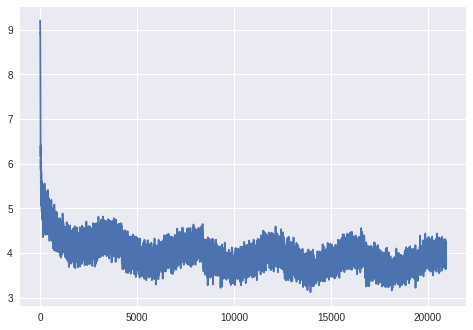

In [0]:
print(arr_lost[:5])
plt.plot(arr_lost)

# plt.ylabel('Entropy loss')
# plt.show()

In [0]:
from google.colab import files
files.download( "model.pickle" ) 

FileNotFoundError: ignored

In [0]:
# tf.global_variables_initializer()
saver = tf.train.Saver()
with tf.Session() as sess:

    saver.restore(sess, '/tmp/model.pickle')
  
    
    context = 'go to'.split()
    ids = [vocab.get_id(x) for x in context]
    ids =  ids + [0]*(config.num_steps - len(ids))
    ids = np.reshape(ids, [1,-1])
    print('ids=', ids)

    p = trainer.test(sess, ids)
  
    print('p=', p.shape)
    max_ids = np.argsort(p,axis=2)[:,:,-3:]
#     print('raw max_id=', max_ids)


    f_getword = lambda id: vocab.get_word(id)
    func = np.vectorize(f_getword)
    max_words = func(max_ids)
    print(max_words)


INFO:tensorflow:Restoring parameters from /tmp/model.pickle
ids= [[92  7  0  0  0]]
prediction shape: Tensor("Shape_8:0", shape=(3,), dtype=int32)
p= (1, 5, 10004)
[[['up' 'to' '<unk>']
  ['be' '<unk>' 'the']
  ['the' '<PAD>' '<unk>']
  ['you' '<unk>' '<PAD>']
  ['thy' '<unk>' '<PAD>']]]


## Find similar words

In [0]:
saver = tf.train.Saver()
with tf.Session() as sess:

    saver.restore(sess, '/tmp/model.pickle')
    k = sess.run(trainer.most_similar(sess, [vocab.get_id('up')]))
    top_id = k.indices[0]
    words = list(map(lambda wid: vocab.get_word(wid), top_id))
    print (top_id)
    print (words)


INFO:tensorflow:Restoring parameters from /tmp/model.pickle
[  62 6629 4676]
['up', 'laboured', 'panel']


In [0]:
t1 = [[10, 2, 3,4,5], [6,7,8,9,10]]

t2 = [[11, 12, 13,14,15], [16,17,18,19,20]]
np.argmax(t1, axis=0)

In [0]:
import numpy as np
t3 = np.concatenate([t1,t2],1)
print (t3)

[[10  2  3  4  5 11 12 13 14 15]
 [ 6  7  8  9 10 16 17 18 19 20]]


In [0]:
np.random.seed(42)
t3 = np.random.rand(20,8)
dataset = tf.data.Dataset.from_tensor_slices(t3).batch(3)
iter = dataset.make_initializable_iterator()
element_next = iter.get_next()

with tf.Session() as sess:
    epoch = 1
    while(epoch < 2):
        sess.run(iter.initializer)
        while(True):
          try:
              v = sess.run(element_next)
              print(v.shape, v)
          except tf.errors.OutOfRangeError:
              print('finished epoch %d'%(epoch))
              epoch+=1
              break

((3, 8), array([[0.37454012, 0.95071431, 0.73199394, 0.59865848, 0.15601864,
        0.15599452, 0.05808361, 0.86617615],
       [0.60111501, 0.70807258, 0.02058449, 0.96990985, 0.83244264,
        0.21233911, 0.18182497, 0.18340451],
       [0.30424224, 0.52475643, 0.43194502, 0.29122914, 0.61185289,
        0.13949386, 0.29214465, 0.36636184]]))
((3, 8), array([[0.45606998, 0.78517596, 0.19967378, 0.51423444, 0.59241457,
        0.04645041, 0.60754485, 0.17052412],
       [0.06505159, 0.94888554, 0.96563203, 0.80839735, 0.30461377,
        0.09767211, 0.68423303, 0.44015249],
       [0.12203823, 0.49517691, 0.03438852, 0.9093204 , 0.25877998,
        0.66252228, 0.31171108, 0.52006802]]))
((3, 8), array([[0.54671028, 0.18485446, 0.96958463, 0.77513282, 0.93949894,
        0.89482735, 0.59789998, 0.92187424],
       [0.0884925 , 0.19598286, 0.04522729, 0.32533033, 0.38867729,
        0.27134903, 0.82873751, 0.35675333],
       [0.28093451, 0.54269608, 0.14092422, 0.80219698, 0.0745506

In [0]:
tmp = np.concatenate([t1,t2],0)

In [0]:
pt =np.array([[[1,2,3],[11,22,33],[111,222,333]],
              [[7,8,9],[77,88,99],[777,888,999]]])
print(pt.shape)
tf.concat(pt, 1)

(2, 3, 3)


<tf.Tensor 'concat_4:0' shape=(2, 3, 3) dtype=int64>

In [0]:
# dataset2 = tf.data.Dataset.from_tensor_slices((training_data, training_labels))
# print ('X=', training_data.shape)
# print ('labels=', training_labels.shape)
# features = tf.placeholder(tf.float32, shape=[None,30])
# labels =  tf.placeholder(tf.float32, shape=[None,30])

# dataset2 = tf.data.Dataset.from_tensor_slices((features[:101], labels[:101])).shuffle(100).batch(25)

# iter = dataset2.make_initializable_iterator()
# x,y = iter.get_next()

# counter = 1
# with tf.Session() as sess:
#     sess.run(iter.initializer, feed_dict={ features: training_data,
#                                                labels: training_labels }) 
#     for e in range(config.max_epoch):
#         print('Running Epoch: %d'%(e+1))
        
#         try:
#             while(True):
#                 result = sess.run([x,y])
#                 print('batch:%d, %s'%(counter,result[0].shape))
#                 counter += 1
#         except tf.errors.OutOfRangeError:
#             counter = 1
#             sess.run(iter.initializer, feed_dict={ features: training_data,
#                                                labels: training_labels }) 

### tf dataset shuffle buffer can be replentish at any time, if your buffer size is smaller than the total number of elements,the fist N elements may contain elements from outside the buffer_size

In [0]:


dataset = tf.data.Dataset.from_tensor_slices([1,2,3,4,5,6,7,8]).shuffle(buffer_size=4, seed=42).batch(2)
iter = dataset.make_initializable_iterator() # create the iterator
el = iter.get_next()
with tf.Session() as sess:
    # feed the placeholder with data
    sess.run(iter.initializer) 
    print('batch:', sess.run(el))
    print('run batch:', sess.run(el))
#     print('run batch:', sess.run(el)) # output [ 0.52374458  0.71968478

batch: [2 5]
run batch: [3 4]
